In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

torch.cuda.set_device(0)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
PATH = "../input/"
sz = 224
arch = resnet101
bs = 58

In [4]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [5]:
n

25361

In [6]:
len(val_idxs)

5072

In [7]:
!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

!tar xvfz fastai/weights.tgz -C fastai

fastai/weights.tgz: No such file or directory
tar (child): fastai/weights.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [8]:
!ls {PATH}

sample_submission.csv  test  train  train.csv


In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [12]:
label_df.pivot_table(index="Id", aggfunc=len).sort_values('Image', ascending=False)

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50


In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

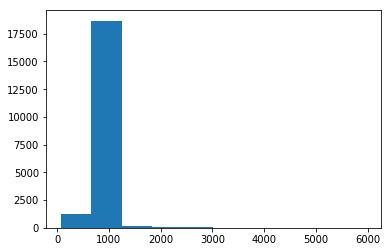

In [16]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

row_sz, col_sz = list(zip(*size_d.values()))

row_sz = np.array(row_sz); col_sz = np.array(col_sz)

row_sz[:5]

plt.hist(row_sz);

In [ ]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


In [18]:
import pathlib
data.path = pathlib.Path('.')

In [21]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:07<00:00, 23158226.89it/s]


  0%|          | 0/350 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 138/138 [02:35<00:00,  1.77it/s]


In [22]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      6.025566   5.639935   0.384858  
    1      5.384762   5.407149   0.388604                   
    2      5.081916   5.277784   0.389984                   
    3      4.819561   5.15253    0.394716                   
    4      4.62229    5.060253   0.399054                   



[5.060253240426632, 0.3990536235472663]

In [23]:
from sklearn import metrics

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [25]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.971084   5.638065   0.381901  
    1      5.472604   5.432956   0.38683                    



[5.43295613485932, 0.38682964711511736]

In [26]:
learn.precompute = False

In [27]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.412887   5.368191   0.388801  
    1      5.377327   5.311944   0.389393                   
    2      5.204738   5.261622   0.390773                   
    3      5.152983   5.207377   0.390181                   
    4      5.053626   5.167789   0.393336                   



[5.16778946787777, 0.3933359590720397]

In [28]:
learn.save('224_pre')

learn.load('224_pre')

In [29]:
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, tfms=tfms, bs=32)

In [30]:
learn.freeze()

In [ ]:
learn.fit(1e-2, 5, cycle_len=1)

  0%|          | 0/350 [00:00<?, ?it/s]